# Comprehensive MNIST & Fashion-MNIST Classification Pipeline
This notebook contains a full implementation of the enhanced machine learning pipeline for MNIST and Fashion-MNIST classification using classical models. All visualizations and outputs are shown in notebook cells.
---

**Outline:**
1. Required Libraries and Data Preprocessing
2. DigitClassificationPipeline Class
3. Run MNIST Pipeline and evaluate
4. Run Fashion-MNIST Pipeline and evaluate

In [64]:


import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image

import sys
import os

from collections import Counter

import matplotlib.pyplot as plt
from matplotlib.patches import Patch


from sklearn.decomposition import PCA, TruncatedSVD, KernelPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors , KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_val_score ,  GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, silhouette_score
from sklearn.metrics import recall_score, precision_score, f1_score

from sklearn.preprocessing import StandardScaler


from sklearn.utils import shuffle
from scipy.stats import entropy
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')


import cv2
from collections import Counter


from scipy import ndimage
from scipy.ndimage import rotate, shift, gaussian_filter
from skimage.feature import hog, local_binary_pattern
from skimage import exposure

import torch
from torchvision import datasets, transforms



In [65]:


class DigitClassificationPipeline:
    
    def __init__(self, data_path='data', target_samples=1000, image_size=(28,28), 
                 feature_method='pca',  optimize_samples=True,  dataset_name='mnist'):


        
        self.data_path = data_path
        self.target_samples = target_samples
        self.image_size = image_size
        self.feature_method = feature_method
        self.optimize_samples = optimize_samples
        self.dataset_name = dataset_name
        
        self.images = []
        self.labels = []
        
        self.features = None
        self.selected_features = None
        
        self.models = {}
        self.results = {}
        
        self.pca = None
        
        self.erf_kernel_size = 3
        self.erf_sigma = 0.5
        
        self.optimal_samples = target_samples
        self.optimal_tree_params = {}


        
    def load_data(self):
        
        print(f"\n--- Loading {self.dataset_name.upper()} data from torchvision ---")
        
        transform = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.Grayscale(),
            transforms.ToTensor(),
            #transforms.Lambda(lambda x: (x > 0.5).float()), # binarize
            transforms.Lambda(lambda x: x.squeeze())
        ])


        
        if self.dataset_name == 'mnist':
            dataset = datasets.MNIST(root='./', train=True, download=True, transform=transform)
        elif self.dataset_name == 'fashion':
            dataset = datasets.FashionMNIST(root='./', train=True, download=True, transform=transform)
        else:
            raise ValueError('Unknown dataset')

            
        images = []
        labels = []
        
        for img, label in dataset:
            img_array = (img.numpy() * 255).astype('uint8').flatten()
            images.append(img_array)
            labels.append(label)

            
        self.images = np.array(images)
        self.labels = np.array(labels)

        
        #print(f"Loaded {len(self.images)} images with shape {self.images[0].shape} (resized to {self.image_size[0]}x{self.image_size[1]}, binarized)")
        print(f"Loaded {len(self.images)} images with shape {self.images[0].shape} (resized to {self.image_size[0]}x{self.image_size[1]}, not binarized)")


        
        plt.figure(figsize=(6, 4))
        
        unique, counts = np.unique(self.labels, return_counts=True)
        
        plt.bar(unique, counts)
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.title('Class Distribution After Loading')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()




        
    def filter_data(self):
        
        print("\n--- Filtering data ---")
        
        variances = np.var(self.images, axis=1)
        variance_threshold = np.percentile(variances, 1)
        mean_brightness = np.mean(self.images, axis=1)
        brightness_lower = 5
        brightness_upper = 250

        
        valid_indices = (variances > variance_threshold) & \
                       (mean_brightness > brightness_lower) & \
                       (mean_brightness < brightness_upper)


        
        self.images = self.images[valid_indices]
        self.labels = self.labels[valid_indices]

        
        print(f"After filtering: {len(self.images)} images remaining")



        
        plt.figure(figsize=(6, 4))
        
        unique, counts = np.unique(self.labels, return_counts=True)
        
        plt.bar(unique, counts)
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.title('Class Distribution After Filtering')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()







        
    def density_based_subsampling(self, n_neighbors=5, contamination=0.05):
        
        print("\n--- Density-based subsampling ---")
        
        contamination = 0.02
        
        sample_size = min(5000, len(self.images))
        
        sample_indices = np.random.choice(len(self.images), sample_size, replace=False)
        
        sample_images = self.images[sample_indices]
        
        n_components = min(49, sample_images.shape[1] - 1)
        
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        
        reduced_images = svd.fit_transform(sample_images)
        
        nn = NearestNeighbors(n_neighbors=n_neighbors)
        
        nn.fit(reduced_images)
        
        distances, _ = nn.kneighbors(reduced_images)
        
        density_scores = 1 / (np.mean(distances, axis=1) + 1e-10)
        
        threshold = np.percentile(density_scores, contamination * 100)
        
        dense_indices = sample_indices[density_scores > threshold]



        
        if len(dense_indices) < 2000:
            print(f"Density filtering would remove too many samples ({len(dense_indices)} left), skipping...")
            return


            
        self.images = self.images[dense_indices]
        self.labels = self.labels[dense_indices]

        
        print(f"After density-based subsampling: {len(self.images)} images remaining")




        
        plt.figure(figsize=(6, 4))
        
        unique, counts = np.unique(self.labels, return_counts=True)
        
        plt.bar(unique, counts)
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.title('Class Distribution After Density Subsampling')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()




        
    def entropy_based_ordering_for_subset(self):
        
        print("\n--- Entropy-based ordering for subset selection ---")
        
        entropies = []



        
        for img in self.images:
            
            hist, _ = np.histogram(img, bins=256, range=(0, 256))
            hist = hist / np.sum(hist)
            img_entropy = entropy(hist + 1e-10)
            entropies.append(img_entropy)
            
        entropies = np.array(entropies)
        
        sorted_indices = np.argsort(entropies)[::-1]   # anti-curriculum learning for subset selection
        #sorted_indices = np.argsort(entropies)    # curriculum learning when training
        
        self.images = self.images[sorted_indices]
        self.labels = self.labels[sorted_indices]

        
        #print(f"Data ordered by entropy (lowest to highest)")
        print(f"Data ordered by entropy (highest to lowest) for subset selection")

        
        plt.figure(figsize=(6, 4))
        plt.hist(entropies, bins=30, color='purple', alpha=0.7)
        plt.xlabel('Entropy')
        plt.ylabel('Frequency')
        plt.title('Entropy Distribution of Images')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()




        
    def select_samples(self):

        print("\n--- Selecting optimal samples ---")
        
        if self.optimize_samples:
            
            if hasattr(self, 'optimize_sample_size') and callable(getattr(self, 'optimize_sample_size')):
                self.optimal_samples = self.optimize_sample_size()
            else:
                self.optimal_samples = self.target_samples
        else:
            self.optimal_samples = self.target_samples



            
        print(f"Selecting {self.optimal_samples} samples...")



        
        samples_per_class = self.optimal_samples // 10
        
        selected_images = []
        selected_labels = []


        
        for digit in range(10):
            
            digit_indices = [i for i, label in enumerate(self.labels) if label == digit]
            
            if len(digit_indices) >= samples_per_class:
                
                selected_indices = digit_indices[:samples_per_class]
                selected_images.extend([self.images[i] for i in selected_indices])
                selected_labels.extend([self.labels[i] for i in selected_indices])
                
            else:
                selected_images.extend([self.images[i] for i in digit_indices])
                selected_labels.extend([self.labels[i] for i in digit_indices])

                
        self.images = np.array(selected_images)
        self.labels = np.array(selected_labels)
        
        print(f"Selected {len(self.images)} samples")
        
        print(f"Class distribution: {[list(self.labels).count(i) for i in range(10)]}")



        
        plt.figure(figsize=(6, 4))
        
        unique, counts = np.unique(self.labels, return_counts=True)
        
        plt.bar(unique, counts)
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.title('Class Distribution After Selection')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()




        """
        print("\n--- Applying Gaussian Blur ---")
        
        self.images = self.apply_effective_receptive_field(self.images)
        plt.figure(figsize=(8, 2))

        

        
        for i in range(5):
            plt.subplot(1, 5, i+1)
            plt.imshow(self.images[i].reshape(self.image_size), cmap='gray')
            plt.axis('off')
        plt.suptitle('Sample Images After ERF')
        plt.tight_layout()
        plt.show()



        
        if self.apply_augmentation:
            
            print("\n--- Applying data augmentation ---")
            self.images, self.labels = self.augment_data(self.images, self.labels)
            plt.figure(figsize=(8, 2))

            
            for i in range(5):
                plt.subplot(1, 5, i+1)
                plt.imshow(self.images[-(i+1)].reshape(self.image_size), cmap='gray')
                plt.axis('off')
            plt.suptitle('Sample Augmented Images')
            plt.tight_layout()
            plt.show()

            """










    
            
    def extract_features(self):
        
        print("\n--- Feature extraction ---")
        
        print(f"Extracting features using method: {self.feature_method}")
        if self.feature_method == 'hog':
            self.features = self.extract_hog_features(self.images)
        elif self.feature_method == 'sift':
            self.features = self.extract_sift_features(self.images)
        elif self.feature_method == 'lbp':
            self.features = self.extract_lbp_features(self.images)
        elif self.feature_method == 'pca':
            self.extract_features_svd()
            self.apply_pca()
            self.apply_feature_whitening()
            return
        else:
            raise ValueError(f"Unknown feature method: {self.feature_method}")

            
        self.selected_features = self.features

        
        print(f"Final features shape: {self.selected_features.shape}")



        
        if self.selected_features is not None and self.selected_features.shape[1] >= 2:
            
            plt.figure(figsize=(6, 5))
            plt.scatter(self.selected_features[:, 0], self.selected_features[:, 1], c=self.labels, cmap='tab10', alpha=0.5, s=10)
            plt.xlabel('Feature 1')
            plt.ylabel('Feature 2')
            plt.title('Feature Scatter Plot (First 2 Features)')
            plt.colorbar()
            plt.tight_layout()
            plt.show()



    """




            
    def extract_features_svd(self, n_components=100):
        
        print("\n--- SVD feature extraction ---")

        max_components = min(n_components, self.images.shape[1] - 1)
        
        print(f"Extracting features using SVD with {max_components} components...")
        
        normalized_images = self.images / 255.0
        
        svd = TruncatedSVD(n_components=max_components, random_state=42)
        
        self.features = svd.fit_transform(normalized_images)
        
        print(f"Features shape: {self.features.shape}")
        print(f"Explained variance ratio: {svd.explained_variance_ratio_[:10]}")



    

        
    def apply_pca(self, target_variance=0.95):
        
        print("\n--- PCA dimensionality reduction ---")
        
        print(f"Determining optimal PCA components for {target_variance*100}% variance...")
        
        max_components = min(self.features.shape[1], self.features.shape[0] - 1)
        
        pca_full = PCA(n_components=max_components, random_state=42)
        pca_full.fit(self.features)
        
        cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
        
        n_components_needed = np.argmax(cumulative_variance >= target_variance) + 1
        n_components_needed = min(n_components_needed, max_components)
        
        print(f"Components needed for {target_variance*100}% variance: {n_components_needed}")
        print(f"Actual variance captured: {cumulative_variance[n_components_needed-1]:.4f}")
        
        self.pca = PCA(n_components=n_components_needed, random_state=42)
        self.selected_features = self.pca.fit_transform(self.features)
        
        print(f"PCA features shape: {self.selected_features.shape}")
        print(f"PCA explained variance ratio (first 10): {self.pca.explained_variance_ratio_[:10]}")
        print(f"Total variance explained: {np.sum(self.pca.explained_variance_ratio_):.4f}")

        
        self.pca_full = pca_full
        self.cumulative_variance = cumulative_variance
        self.n_components_needed = n_components_needed
        self.visualize_pca_components()
        self.visualize_variance_analysis()



    
        
    def visualize_pca_components(self, n_components_to_show=12):
        
        print("\n--- Visualizing principal components ---")
        
        pca_components = self.pca.components_
        
        #if hasattr(self, 'scaler'):
            #pca_in_svd_space = pca_components * self.scaler.scale_
            #pca_in_svd_space = pca_in_svd_space + self.scaler.mean_
        #else:
            #pca_in_svd_space = pca_components
        
        pca_in_svd_space = pca_components
        
        
        if hasattr(self, 'svd_transformer'):
            
            pca_in_pixel_space = pca_in_svd_space @ self.svd_transformer.components_
            
        else:
            
            pca_in_pixel_space = pca_in_svd_space

            
        fig, axes = plt.subplots(3, 4, figsize=(12, 9))
        
        axes = axes.flatten()



        
        for i in range(min(n_components_to_show, len(pca_components))):
            
            ax = axes[i]
            
            component_img = pca_in_pixel_space[i].reshape(self.image_size)
            
            component_img = (component_img - component_img.min()) / (component_img.max() - component_img.min())
            
            ax.imshow(component_img, cmap='RdBu_r', aspect='equal')
            
            ax.set_title(f'PC {i+1}\n(Var: {self.pca.explained_variance_ratio_[i]:.3f})')
            
            ax.axis('off')


            
        for i in range(n_components_to_show, len(axes)):
            
            axes[i].axis('off')
            
        plt.suptitle(f'Principal Components ({self.image_size[0]}x{self.image_size[1]} binarized images)', fontsize=14)
        plt.tight_layout()
        plt.show()


    """





    

    def extract_features_svd(self, n_components=100):
        
         print("\n--- SVD feature extraction ---")
         max_components = min(n_components, self.images.shape[1] - 1)
         print(f"Extracting features using SVD with {max_components} components...")

         normalized_images = self.images / 255.0
         self.svd_transformer = TruncatedSVD(n_components=max_components, random_state=42)
         self.features = self.svd_transformer.fit_transform(normalized_images)

         print(f"Features shape: {self.features.shape}")
         print(f"Explained variance ratio: {self.svd_transformer.explained_variance_ratio_[:10]}")



    
    def apply_pca(self, target_variance=0.95):
        
         print("\n--- PCA dimensionality reduction ---")
         print(f"Determining optimal PCA components for {target_variance*100}% variance...")

         max_components = min(self.features.shape[1], self.features.shape[0] - 1)

         pca_full = PCA(n_components=max_components, random_state=42)
         pca_full.fit(self.features)

         cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
         n_components_needed = np.argmax(cumulative_variance >= target_variance) + 1
         n_components_needed = min(n_components_needed, max_components)

         print(f"Components needed for {target_variance*100}% variance: {n_components_needed}")
         print(f"Actual variance captured: {cumulative_variance[n_components_needed-1]:.4f}")

         self.pca = PCA(n_components=n_components_needed, random_state=42)
         self.selected_features = self.pca.fit_transform(self.features)

         print(f"PCA features shape: {self.selected_features.shape}")
         print(f"PCA explained variance ratio (first 10): {self.pca.explained_variance_ratio_[:10]}")
         print(f"Total variance explained: {np.sum(self.pca.explained_variance_ratio_):.4f}")

         self.pca_full = pca_full
         self.cumulative_variance = cumulative_variance
         self.n_components_needed = n_components_needed

         self.visualize_pca_components()
         self.visualize_variance_analysis()





    def visualize_pca_components(self, n_components_to_show=12):
         print("\n--- Visualizing principal components ---")
         pca_components = self.pca.components_

         # PCA components backprojection
         if hasattr(self, 'svd_transformer'):
             
             # PCA components x SVS components ; back to original pixel space
             pca_in_pixel_space = pca_components @ self.svd_transformer.components_
             
         else:
             raise AttributeError("SVD transformer (svd_transformer) not found. Cannot project PCA components back to image space.")

         fig, axes = plt.subplots(3, 4, figsize=(12, 9))
         axes = axes.flatten()

         for i in range(min(n_components_to_show, len(pca_components))):
             ax = axes[i]
             try:
                 component_img = pca_in_pixel_space[i].reshape(self.image_size)
                 
             except ValueError:
                 print(f"Cannot reshape component {i}, skipping.")
                 continue



             
             # Normalize for visualization
             
             component_img = (component_img - component_img.min()) / (component_img.max() - component_img.min())
             ax.imshow(component_img, cmap='RdBu_r', aspect='equal')
             ax.set_title(f'PC {i+1}\n(Var: {self.pca.explained_variance_ratio_[i]:.3f})')
             ax.axis('off')

         for i in range(n_components_to_show, len(axes)):
             axes[i].axis('off')

         plt.suptitle(f'Principal Components ({self.image_size[0]}x{self.image_size[1]} binarized images)', fontsize=14)
         plt.tight_layout()
         plt.show()





    
        
    def visualize_variance_analysis(self):
        
        print("\n--- Visualizing PCA variance analysis ---")
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        ax1 = axes[0]
        n_components = len(self.cumulative_variance)
        
        ax1.plot(range(1, n_components + 1), self.cumulative_variance, 'b-', linewidth=2, label='Cumulative Variance')
        
        ax1.axhline(y=0.95, color='r', linestyle='--', linewidth=2, label='95% Target')
        
        ax1.axvline(x=self.n_components_needed, color='g', linestyle='--', linewidth=2, 
                   label=f'Optimal: {self.n_components_needed} components')
        
        ax1.fill_between(range(1, self.n_components_needed + 1), 
                        self.cumulative_variance[:self.n_components_needed], 
                        alpha=0.3, color='green', label='Selected Components')


        
        ax1.set_xlabel('Number of Components')
        ax1.set_ylabel('Cumulative Variance Explained')
        ax1.set_title(f'PCA Variance Analysis ({self.image_size[0]}x{self.image_size[1]} images)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(0, 1)

        
        ax1.annotate(f'{self.n_components_needed} components\n{self.cumulative_variance[self.n_components_needed-1]:.3f} variance', 
                    xy=(self.n_components_needed, self.cumulative_variance[self.n_components_needed-1]),
                    xytext=(self.n_components_needed + n_components*0.1, 0.8),
                    arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
                    fontsize=10, ha='left')

        
        ax2 = axes[1]
        n_components_show = min(16, len(self.pca_full.explained_variance_ratio_))
        bars = ax2.bar(range(1, n_components_show + 1), 
                      self.pca_full.explained_variance_ratio_[:n_components_show],
                      alpha=0.7, color='blue')


        
        for i in range(min(self.n_components_needed, n_components_show)):
            
            bars[i].set_color('green')
            bars[i].set_alpha(0.8)
        ax2.set_xlabel('Component Number')
        ax2.set_ylabel('Individual Variance Explained')
        ax2.set_title(f'Individual Component Variance (First {n_components_show})')
        ax2.grid(True, alpha=0.3)

        
        legend_elements = [Patch(facecolor='green', alpha=0.8, label='Selected Components'),
                          Patch(facecolor='blue', alpha=0.7, label='Other Components')]
        ax2.legend(handles=legend_elements)
        plt.tight_layout()
        plt.show()



        


# just normalizing...
    
    def apply_feature_whitening(self):
        
        print("\n--- Feature whitening ---")
        
        self.scaler = StandardScaler()
        self.features = self.scaler.fit_transform(self.features)
        
        print(f"Features after whitening - Mean: {np.mean(self.features, axis=0)[:5]}")
        print(f"Features after whitening - Std: {np.std(self.features, axis=0)[:5]}")

        print(f"\n")
        print(f"\n")









            
    
    
    def optimize_tree_parameters(self, X, y, tree_size_limit=25):
        
        print("Optimizing decision tree parameters...")

        
        param_grid = {
            
            'max_depth': [3, 5, 10, 15],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }


        
        grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=3, n_jobs=-1)
        
        grid.fit(X, y)
        
        best_params = grid.best_params_
        
        print(f"Best tree params: {best_params}")
        
        print(f"\n")
        print(f"\n")
        
        return best_params







    

    def find_optimal_k_elbow(self, X):
        
        print("Finding optimal k using elbow method...")
        
        inertias = []
        
        K_range = range(1, 11)
        
        for k in K_range:
            
            kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
            
            kmeans.fit(X)
            
            inertias.append(kmeans.inertia_)

            
        # Simple elbow logic
        
        deltas = np.diff(inertias)
        
        elbow_k = K_range[np.argmin(deltas) + 1]

        print(f"Selected k = {elbow_k} based on Elbow Method")
        
        print(f"\n")
        print(f"\n")
        
        
        return elbow_k, inertias












    def xmeans_clustering(self, X, k_min=2, k_max=10):
    
        #simplified X-means : KMeans + BIC 
    
        print("Running X-means-like clustering using BIC...")

        def compute_bic(kmeans, X):
        
            #BIC calculation : log-likelihood, model complexity , etc.
        
            n, d = X.shape
            m = kmeans.n_clusters
            centers = kmeans.cluster_centers_
            labels = kmeans.labels_

        
            # cluster variance (inertia / n_samples)
            cl_var = (1.0 / (n - m) / d) * kmeans.inertia_

            if cl_var == 0:
                cl_var = 1e-6  # Numerical stability

            log_likelihood = -0.5 * n * d * np.log(2 * np.pi * cl_var) - 0.5 * (n - m) * d
            
            n_parameters = m * d  # centers
            
            bic = log_likelihood - 0.5 * n_parameters * np.log(n)

            return bic

        best_bic = -np.inf
        best_k = k_min




        for k in range(k_min, k_max + 1):
            
            kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42)
            
            kmeans.fit(X)
            
            bic = compute_bic(kmeans, X)

            print(f"k = {k}, BIC = {bic:.2f}")
            
            if bic > best_bic:
                
                best_bic = bic
                best_k = k

        print(f"Selected k = {best_k} based on highest BIC")

        print(f"\n")
        print(f"\n")
        
        return best_k












    def uncertainty_sampling(self, X, y, model, n_samples):
        
        print("Performing uncertainty sampling...")
        
        model.fit(X, y)
        
        probs = model.predict_proba(X)
        
        uncertainty = 1 - np.max(probs, axis=1)
        
        indices = np.argsort(uncertainty)[-n_samples:]
        
        return indices
        










    def margin_sampling(self, X, y, model, n_samples):
        
        print("Performing margin sampling...")
        
        model.fit(X, y)
        
        probs = model.predict_proba(X)
        
        part = np.partition(-probs, 1, axis=1)
        
        margin = -part[:, 0] + part[:, 1]
        
        indices = np.argsort(margin)[:n_samples]
        
        return indices












    def query_by_committee(self, X, y, n_samples):
        
        print("Performing query by committee...")
        
        models = [
            
            #LogisticRegression(max_iter=1000, random_state=0),
            
            DecisionTreeClassifier(random_state=1),
            
            KNeighborsClassifier(n_neighbors=3)
            
        ]


        
        preds = []
        
        for m in models:
            
            m.fit(X, y)
            
            preds.append(m.predict(X))
            
        preds = np.array(preds)
        
        disagreements = np.std(preds, axis=0)
        
        indices = np.argsort(disagreements)[-n_samples:]
        
        return indices









# future work : oracle , user defined labeling...
    
    def majority_voting_labels(self, indices_list, method_names):
        
        print("Applying majority voting on selected indices...")
        

        final_indices = np.unique(np.concatenate(indices_list))
        
        voted_labels = []

        for idx in final_indices:
            
            votes = []
            
            for indices, name in zip(indices_list, method_names):
                
                if idx in indices:
                    
                    votes.append(self.labels[idx])
                    
            if votes:
                label = Counter(votes).most_common(1)[0][0]
            else:
                label = self.labels[idx]

            voted_labels.append(label)

        return np.array(final_indices), np.array(voted_labels)








# not effective and appropriate solution
    
    def optimize_knn_k(self, X_train, y_train, X_val, y_val):
        
        print("Optimizing k for KNN...")
        
        best_k = 1
        best_acc = 0
        
        for k in range(1, 11):
            
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train, y_train)
            
            acc = knn.score(X_val, y_val)
            
            if acc > best_acc:
                best_acc = acc
                best_k = k
                
        print(f"Best k for KNN: {best_k}")

        print(f"\n")
        print(f"\n")
        
        return best_k








    def train_quantized_logistic_regression(self, X, y, bits=8):
        
        print(f"Training and quantizing logistic regression to {bits}-bit...")

        print(f"\n")
        print(f"\n")
        
        model = LogisticRegression(max_iter=1000, random_state=42)
        
        model.fit(X, y)


        if bits < 8:
            
            coef = model.coef_
            coef_min, coef_max = coef.min(), coef.max()
            
            quantized_coef = np.round((coef - coef_min) / (coef_max - coef_min) * (2**bits - 1))
            
            model.coef_ = quantized_coef
            
        return model, None











    def estimate_model_size_bits(self, model, bits=8):
        
        coef_count = model.coef_.size
        
        total_bits = coef_count * bits
        
        size_kb = total_bits / 8 / 1024
        
        print(f"Estimated model size: {size_kb:.2f} kB")

        print(f"\n")
        print(f"\n")
        
        return size_kb








    def select_important_features(self, X, y):
        

        #n_features=len(self.selected_features[0])


        # user defined for now , not optimal...
        n_features=25
            
        print(f"Selecting top {n_features} important features using RF...")

        print(f"\n")
        print(f"\n")
    
        rf = RandomForestClassifier(random_state=42)
    
        rf.fit(X, y)
    
        importances = rf.feature_importances_
    
        top_indices = np.argsort(importances)[-n_features:]
    
        return top_indices
    
    
    
        
    
        
        
        
    
    
    
    
    
    
    
      
            
    def train_models(self):
        
        
        print("\n--- Training all models ---")
        
        X_train, X_test, y_train, y_test = train_test_split(
            
            self.selected_features, self.labels, test_size=0.2, 
            random_state=42, stratify=self.labels
        )


        
        X_train_sub, X_val, y_train_sub, y_val = train_test_split(
            
            X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
        )





        print("\n--- Entropy-based ordering for curriculum learning ---")


        
        entropies = []



        
        for img in X_train:
            
            hist, _ = np.histogram(img, bins=256, range=(0, 256))
            hist = hist / np.sum(hist)
            img_entropy = entropy(hist + 1e-10)
            entropies.append(img_entropy)
            
        entropies = np.array(entropies)
        
        #sorted_indices = np.argsort(entropies)[::-1]   # anti-curriculum learning for subset selection
        sorted_indices = np.argsort(entropies)    # curriculum learning when training
        
        X_train = X_train[sorted_indices]
        y_train = y_train[sorted_indices]

        
        print(f"Data ordered by entropy (lowest to highest) for curriculum learning")
        #print(f"Data ordered by entropy (highest to lowest)")




        
        print("\n=== Training first with Decision Tree...===")
        
        tree_params = self.optimize_tree_parameters(X_train, y_train)
        self.optimal_tree_params = tree_params


        
        
        dt = DecisionTreeClassifier(
            
            max_depth=tree_params['max_depth'],
            min_samples_split=tree_params['min_samples_split'],
            min_samples_leaf=tree_params['min_samples_leaf'],
            random_state=42
        )


        dt.fit(X_train, y_train)




        print("\n=== After ; Decision Tree with Feature Selection + Bagging ===")
        
        feature_importances = self.select_important_features(X_train, y_train)
        

        #n_features=len(self.selected_features[0])

             
        X_train_selected = X_train[:, feature_importances]
        X_test_selected = X_test[:, feature_importances]
        
        dt_selected = DecisionTreeClassifier(random_state=42)
        dt_selected.fit(X_train_selected, y_train)
        
        baseline_accuracy = accuracy_score(y_test, dt.predict(X_test))
        selected_accuracy = accuracy_score(y_test, dt_selected.predict(X_test_selected))

        
        print(f"Decision Tree with Feature Selection + Bagging ; Baseline accuracy: {baseline_accuracy:.4f}")
        print(f"Decision Tree with Feature Selection + Bagging ; Selected features accuracy: {selected_accuracy:.4f}")









        # RF side too
        
        print("\n=== Lastly  ; training with Random Forest too...===")

        rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        
        rf.fit(X_train, y_train)



        



        # not good right know ; will be fix in future works...
        
        print("\n=== METHOD 1: K-means + Active Learning + KNN ===")
        
        
        elbow_k, inertias = self.find_optimal_k_elbow(X_train)
        
        xmeans_k = self.xmeans_clustering(X_train)
        
        
        optimal_cluster_k = max(elbow_k, xmeans_k)  # for future work :  add function to choose best
        
        
        print(f"Using k={optimal_cluster_k} for clustering")

        
        kmeans = KMeans(n_clusters=optimal_cluster_k, random_state=42, n_init="auto")
        
        
        cluster_labels = kmeans.fit_predict(X_train)

        
        n_samples_per_method = min(100, len(X_train) // 10)


        
        
        uncertainty_model = LogisticRegression(random_state=42, max_iter=1000)
        
        uncertainty_indices = self.uncertainty_sampling(X_train, y_train, uncertainty_model, n_samples_per_method)


        
        
        margin_model = SVC(probability=True, random_state=42)
        
        margin_indices = self.margin_sampling(X_train, y_train, margin_model, n_samples_per_method)


        
        
        committee_indices = self.query_by_committee(X_train, y_train, n_samples_per_method)



        
        
        indices_list = [uncertainty_indices, margin_indices, committee_indices]

        
        
        method_names = ['uncertainty', 'margin', 'committee']


        
        
        final_indices, voted_labels = self.majority_voting_labels(indices_list, method_names)
        

        
        X_knn = X_train[final_indices]
        
        y_knn = voted_labels


        
        # normalization 
        
        scaler = StandardScaler()
        X_knn = scaler.fit_transform(X_knn)
        X_val_scaled = scaler.transform(X_val)

        
        
        X_knn, y_knn = shuffle(X_knn, y_knn, random_state=42)
        
        
        optimal_k = self.optimize_knn_k(X_knn, y_knn, X_val, y_val)
        
        
        knn = KNeighborsClassifier(n_neighbors=optimal_k)
        
        
        knn.fit(X_knn, y_knn)







        
        print("\n=== METHOD 2: SVM with Polynomial Kernel ===")
        #print("\n=== METHOD 2: SVM with Polynomial Kernel + Kernel PCA ===")
        
        #print("Applying Kernel PCA...")


        
        #n_components_kpca = 784
        #kpca = KernelPCA(n_components=n_components_kpca, kernel='poly', degree=2, random_state=42)

        
        #X_train_kpca = kpca.fit_transform(X_train)
        #X_test_kpca = kpca.transform(X_test)



        
        print("Training SVM with polynomial kernel...")
        
        svm_poly = SVC(kernel='poly', degree=2, random_state=42, probability=True)
        svm_poly.fit(X_train, y_train)
        
        #svm_poly.fit(X_train_kpca, y_train)













        
        
        print("\n=== METHOD 3: Quantized Logistic Regression ===")
        
        quantized_models = {}
        
        bit_ranges = [1, 2, 4, 8]

        
        for bits in bit_ranges:
            
            print(f"Training {bits}-bit quantized logistic regression...")
            
            quantized_lr, _ = self.train_quantized_logistic_regression(X_train, y_train, bits)
            
            model_size = self.estimate_model_size_bits(quantized_lr, bits)



            """
            if 5 <= model_size <= 200:
                
                quantized_models[f'quantized_lr_{bits}bit'] = {
                    'model': quantized_lr,
                    'bits': bits,
                    'size_kb': model_size
                    
                }

             """


            
            quantized_models[f'quantized_lr_{bits}bit'] = {
                
                    'model': quantized_lr,
                    'bits': bits,
                    'size_kb': model_size
                    
                }







        


        
        self.models['decision_tree'] = dt
        self.models['random_forest'] = rf
        self.models['knn'] = knn
        self.models['svm_poly'] = svm_poly
        self.models['quantized_models'] = quantized_models
        self.models['decision_tree_selected'] = dt_selected
        
        self.results['pca_components'] = self.pca.components_
        self.results['pca_explained_variance'] = self.pca.explained_variance_ratio_
        self.results['cumulative_variance'] = self.cumulative_variance
        self.results['optimal_samples'] = self.optimal_samples
        self.results['optimal_tree_params'] = self.optimal_tree_params
        self.results['feature_importances'] = feature_importances







    def evaluate_all_models(self): 
        
        print("\n=== Evaluating all trained models ===")

        if not hasattr(self, 'models'):
            print("No models found!")
            return

        X_train, X_test, y_train, y_test = train_test_split(
            
        self.selected_features, self.labels, test_size=0.2, random_state=42, stratify=self.labels
            
        )



    
        all_results = []

        for name, model in self.models.items():
            
            if name == 'quantized_models':
                
                for q_name, q_info in model.items():
                    
                    pred = q_info['model'].predict(X_test)
                    
                    self._report_metrics(q_name, y_test, pred)
                    
                    all_results.append((q_name, y_test, pred))


                    
            else:
                try:
                    pred = model.predict(X_test)
                    self._report_metrics(name, y_test, pred)
                    all_results.append((name, y_test, pred))
                    
                except Exception as e:
                    print(f"Model {name} could not be evaluated: {e}")




    
    
        # visualize confusion matrices
        for name, y_true, y_pred in all_results:
            self._plot_confusion_matrix(y_true, y_pred, title=name)









    def _report_metrics(self, model_name, y_true, y_pred):
        
        acc = accuracy_score(y_true, y_pred)
        
        prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
        
        rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
        
        f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

        
        print(f"\n Model: {model_name}")
        
        print(f"Accuracy : {acc:.4f}")
        
        print(f"Precision: {prec:.4f}")
        
        print(f"Recall   : {rec:.4f}")
        
        print(f"F1-score : {f1:.4f}")
        
        print("Detailed classification report:")
        
        print(classification_report(y_true, y_pred, zero_division=0))









    def _plot_confusion_matrix(self, y_true, y_pred, title="Confusion Matrix"):
        
        cm = confusion_matrix(y_true, y_pred)
        
        plt.figure(figsize=(8, 6))
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        
        plt.title(f"{title} - Confusion Matrix")
        
        plt.xlabel("Predicted Label")
        
        plt.ylabel("True Label")
        
        plt.tight_layout()
        
        plt.show()












# only estimate for Quantized Logistic Regression for now...
    
    def estimate_all_model_sizes_and_plot(self, bits=32):
        
        print("\n=== Estimating Model Sizes ===")

        
        if not hasattr(self, 'models'):
            print("No models found.")
            return

        
        model_sizes = []

        
        for name, model in self.models.items():
            
            if name == 'quantized_models':
                
                for qname, qinfo in model.items():
                    
                    size_kb = qinfo.get('size_kb', 0)
                    
                    print(f" {qname} → {size_kb:.2f} kB (quantized)")
                    
                    model_sizes.append((qname, size_kb))
                    
            else:
                
                try:
                    size_kb = self._estimate_model_size(model, bits)
                    
                    print(f"{name} → {size_kb:.2f} kB")
                    
                    model_sizes.append((name, size_kb))

                    
                except Exception as e:
                    print(f"Could not estimate size for {name}: {e}")


        
        if not model_sizes:
            
            print("No model sizes estimated.")
            
            return



        
        
        # visualise
        names, sizes = zip(*model_sizes)

        plt.figure(figsize=(10, 6))

        bars = plt.barh(names, sizes, color='teal', alpha=0.8)

        plt.xlabel("Model Size (kB)")
        plt.title("Estimated Model Sizes")

        plt.gca().invert_yaxis()



        for bar, size in zip(bars, sizes):
            
            plt.text(bar.get_width() + 0.5, bar.get_y() + 0.25, f"{size:.2f} kB", ha='left')

        plt.tight_layout()
        plt.show()



        # DataFrame olarak da döndür (isteğe bağlı)

        #df = pd.DataFrame(model_sizes, columns=["Model", "Size_kB"])
        #return df    
        








    
        
    def run_pipeline(self):
        
        
        print("\n=== PIPELINE START ===")
        
        self.load_data()
        self.filter_data()
        self.density_based_subsampling()
        self.entropy_based_ordering_for_subset()
        self.select_samples()
        self.extract_features()
        self.train_models()

        
        print("\n=== PIPELINE COMPLETED ===\n")






    

# Run MNIST Pipeline


=== PIPELINE START ===

--- Loading MNIST data from torchvision ---
Loaded 60000 images with shape (784,) (resized to 28x28, not binarized)


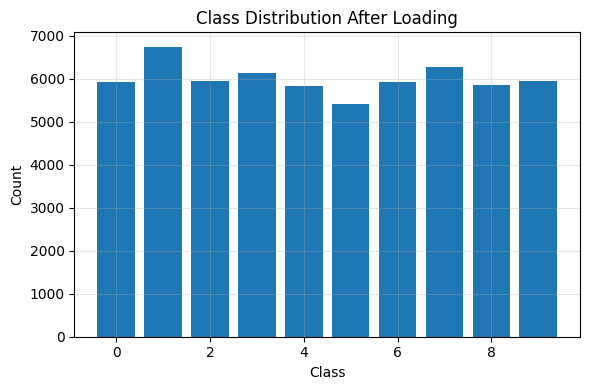


--- Filtering data ---
After filtering: 59400 images remaining


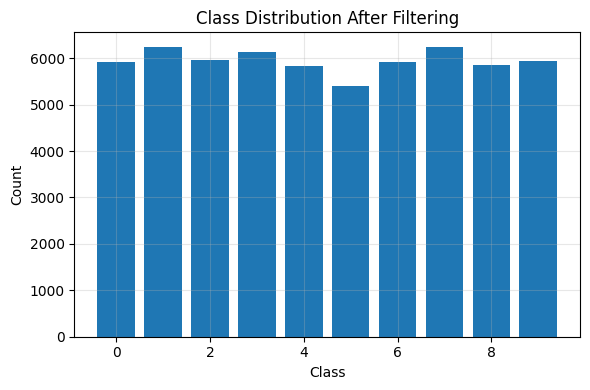


--- Density-based subsampling ---
After density-based subsampling: 4900 images remaining


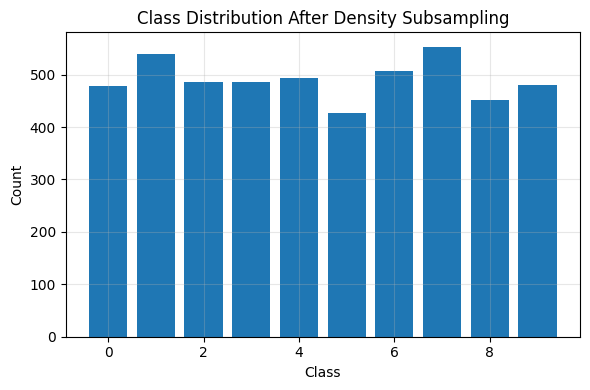


--- Entropy-based ordering for subset selection ---
Data ordered by entropy (highest to lowest) for subset selection


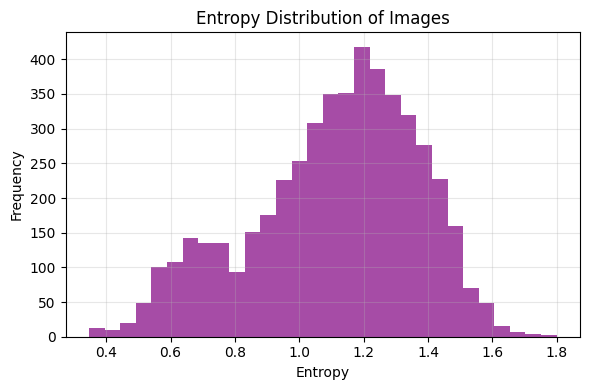


--- Selecting optimal samples ---
Selecting 1000 samples...
Selected 1000 samples
Class distribution: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]


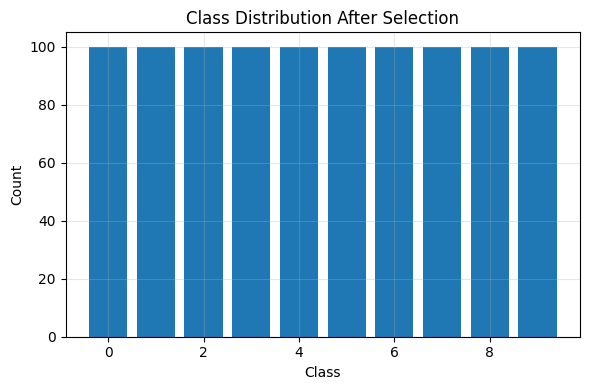


--- Feature extraction ---
Extracting features using method: pca

--- SVD feature extraction ---
Extracting features using SVD with 100 components...
Features shape: (1000, 100)
Explained variance ratio: [0.04482121 0.09706438 0.08540971 0.0687584  0.05951122 0.04200799
 0.04010206 0.03184422 0.03059283 0.02394556]

--- PCA dimensionality reduction ---
Determining optimal PCA components for 95.0% variance...
Components needed for 95.0% variance: 65
Actual variance captured: 0.9505
PCA features shape: (1000, 65)
PCA explained variance ratio (first 10): [0.10777822 0.09968916 0.07391527 0.06424753 0.05237694 0.04488691
 0.03487984 0.03388965 0.03036499 0.0253586 ]
Total variance explained: 0.9505

--- Visualizing principal components ---


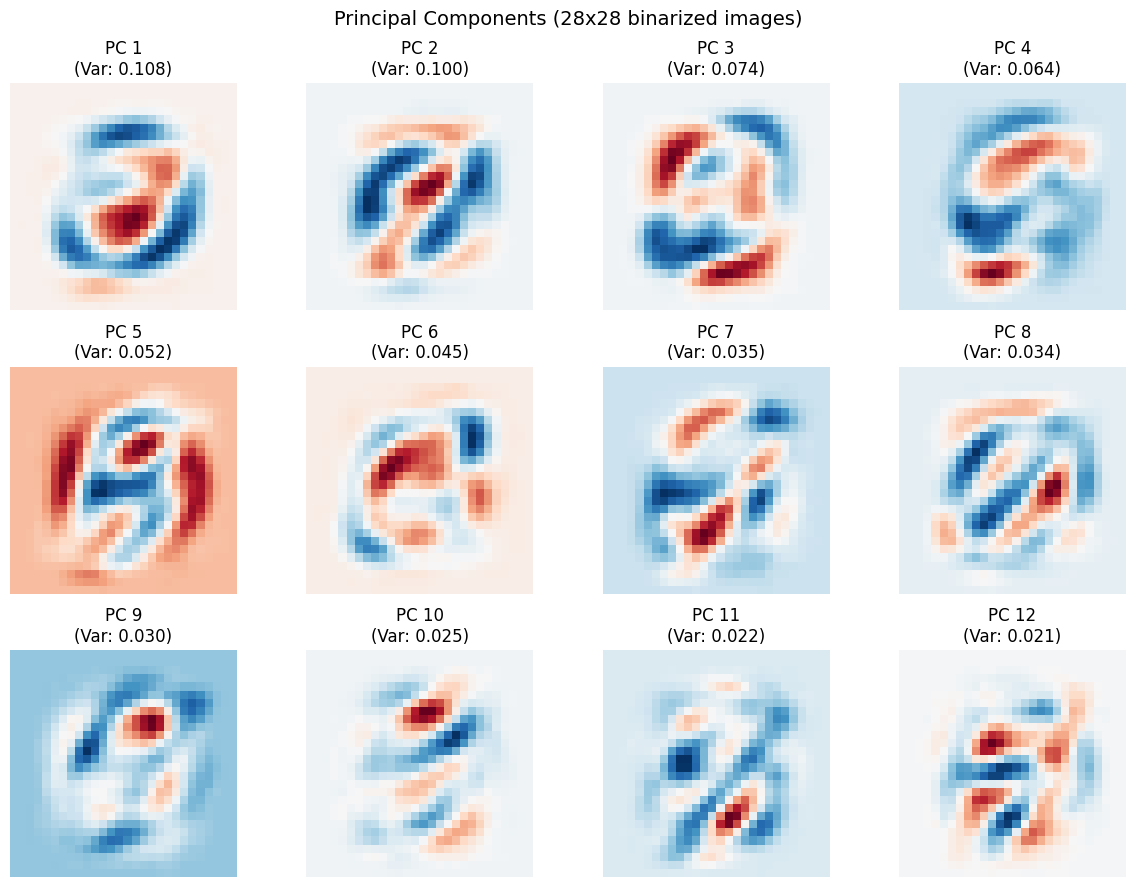


--- Visualizing PCA variance analysis ---


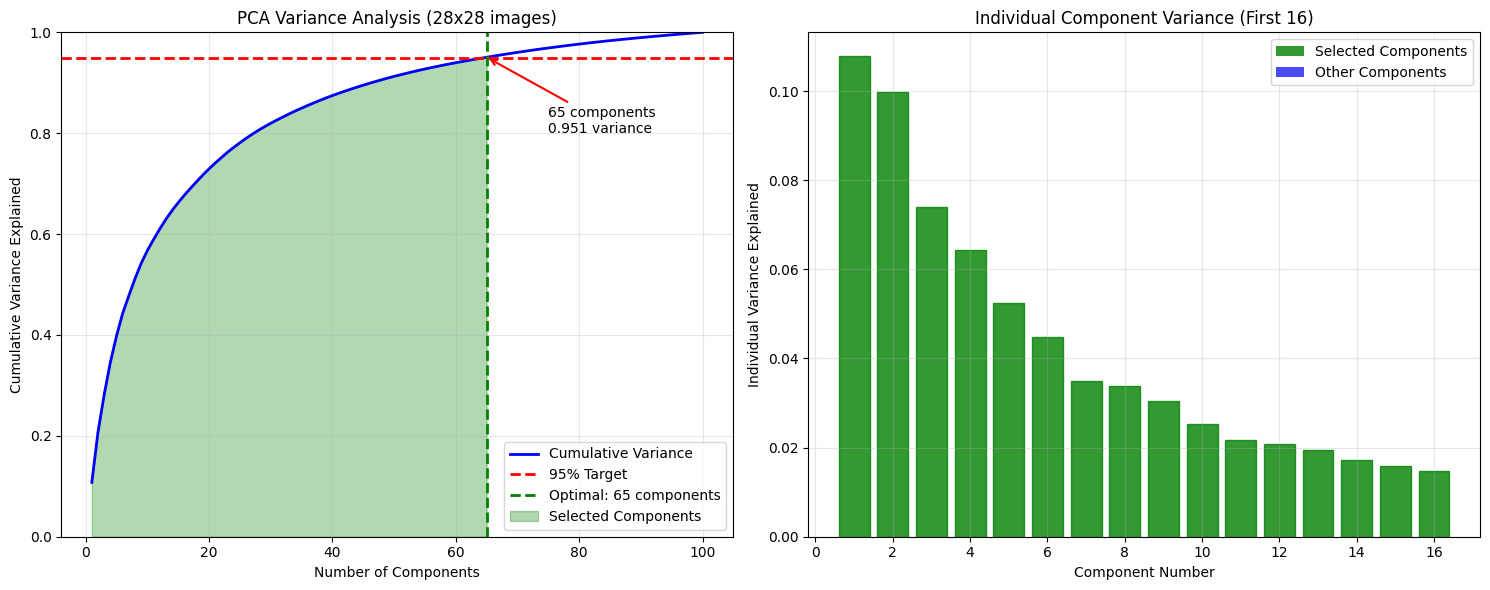


--- Feature whitening ---
Features after whitening - Mean: [ 2.95319325e-16 -2.61901612e-16 -1.98674410e-16  2.24043006e-16
  7.61612995e-17]
Features after whitening - Std: [1. 1. 1. 1. 1.]





--- Training all models ---

--- Entropy-based ordering for curriculum learning ---
Data ordered by entropy (lowest to highest) for curriculum learning

=== Training first with Decision Tree...===
Optimizing decision tree parameters...
Best tree params: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}





=== After ; Decision Tree with Feature Selection + Bagging ===
Selecting top 25 important features using RF...




Decision Tree with Feature Selection + Bagging ; Baseline accuracy: 0.7450
Decision Tree with Feature Selection + Bagging ; Selected features accuracy: 0.7250

=== Lastly  ; training with Random Forest too...===

=== METHOD 1: K-means + Active Learning + KNN ===
Finding optimal k using elbow method...
Selected k = 2 based on Elbow Method




Running X-means-like

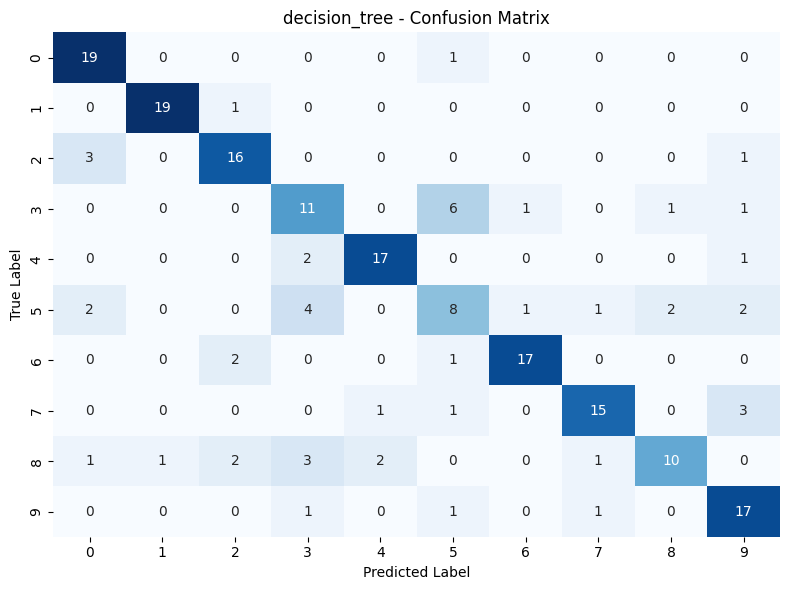

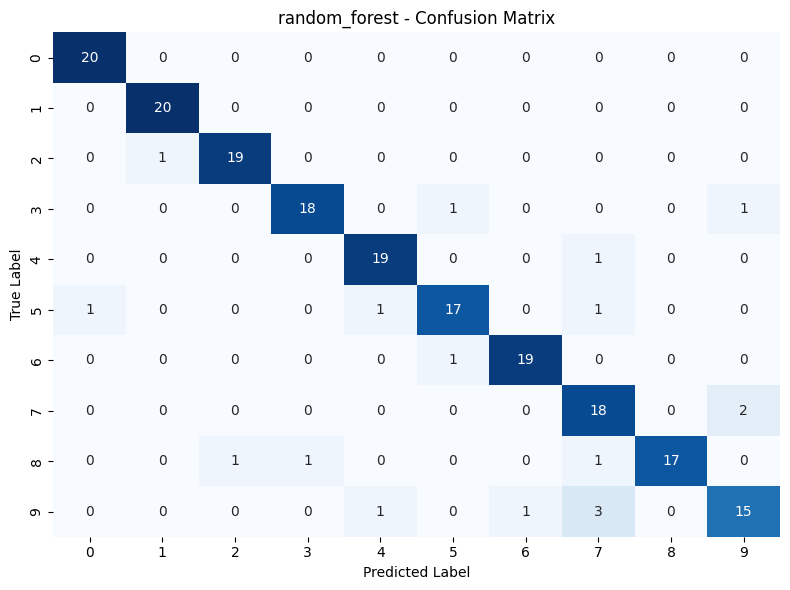

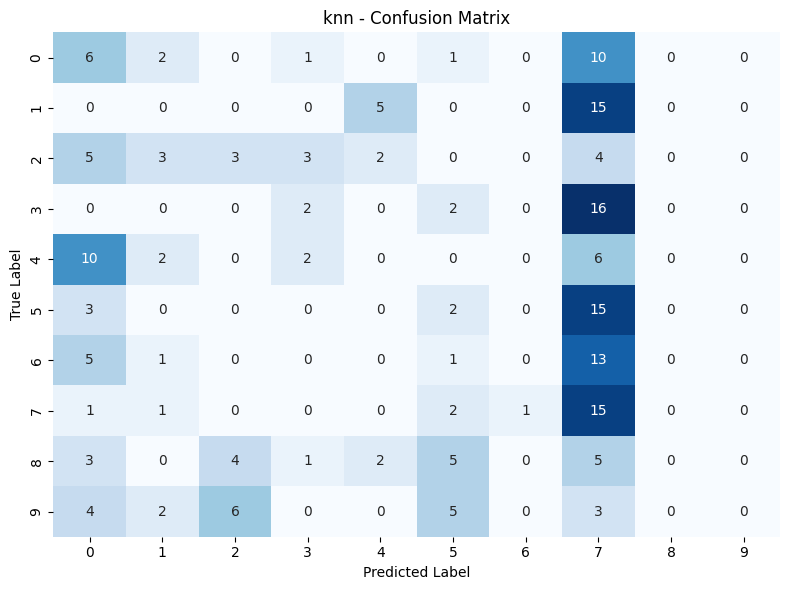

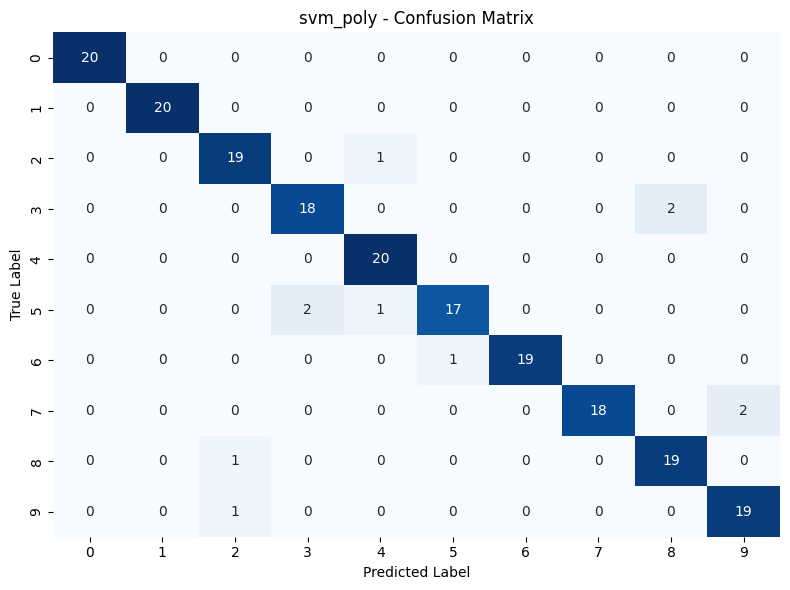

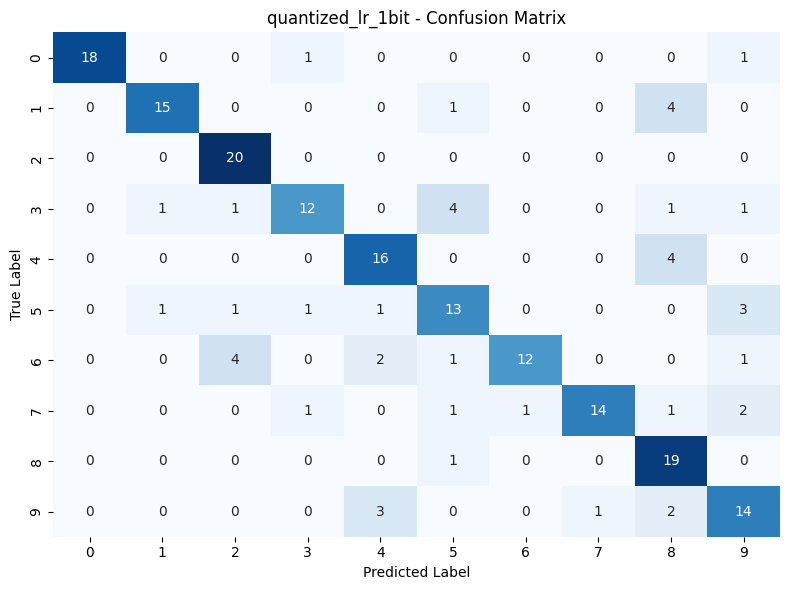

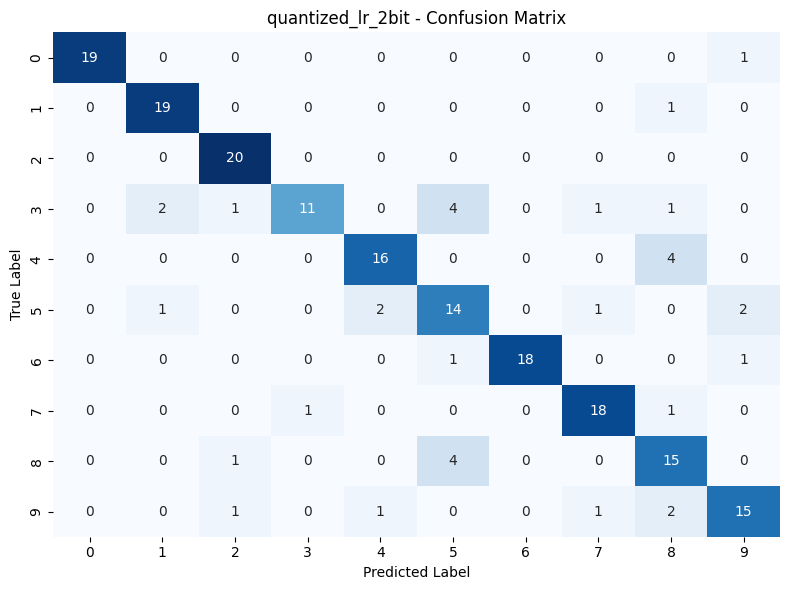

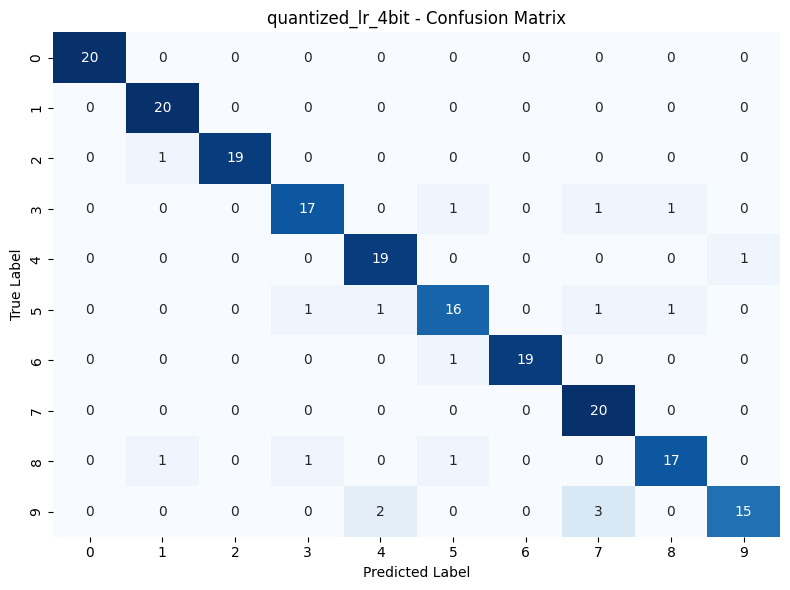

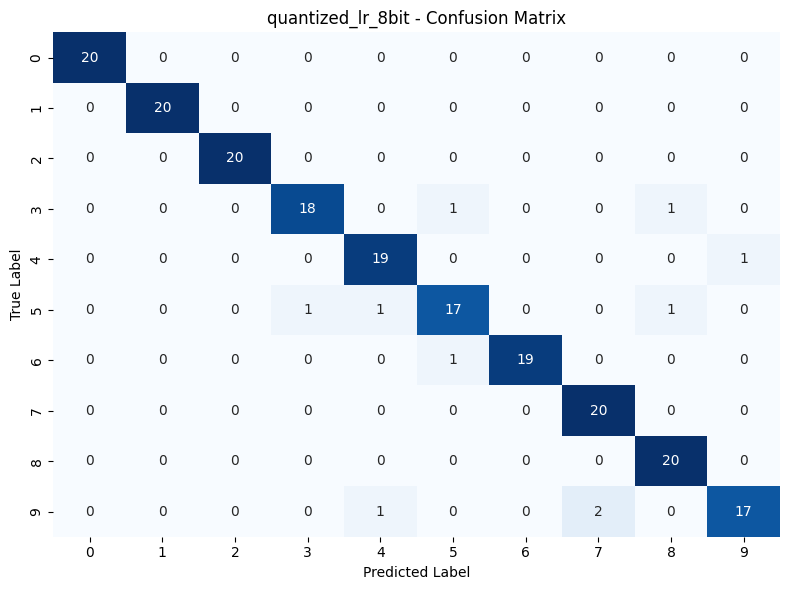


=== Estimating Model Sizes ===
Could not estimate size for decision_tree: 'DigitClassificationPipeline' object has no attribute '_estimate_model_size'
Could not estimate size for random_forest: 'DigitClassificationPipeline' object has no attribute '_estimate_model_size'
Could not estimate size for knn: 'DigitClassificationPipeline' object has no attribute '_estimate_model_size'
Could not estimate size for svm_poly: 'DigitClassificationPipeline' object has no attribute '_estimate_model_size'
 quantized_lr_1bit → 0.08 kB (quantized)
 quantized_lr_2bit → 0.16 kB (quantized)
 quantized_lr_4bit → 0.32 kB (quantized)
 quantized_lr_8bit → 0.63 kB (quantized)
Could not estimate size for decision_tree_selected: 'DigitClassificationPipeline' object has no attribute '_estimate_model_size'


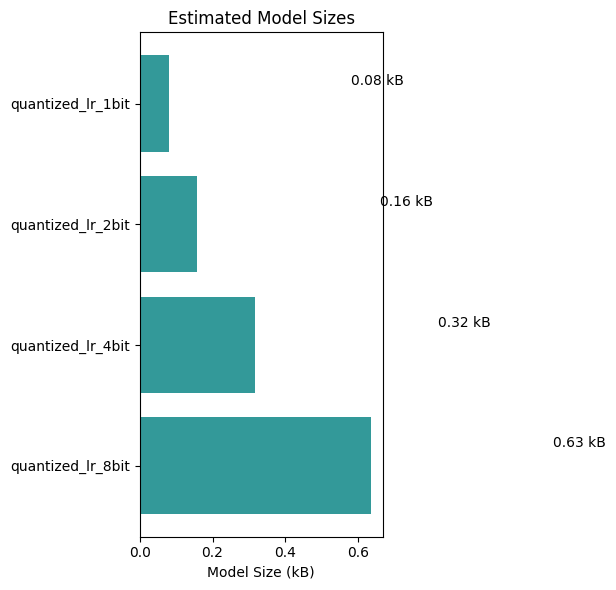

In [66]:




mnist_pipeline = DigitClassificationPipeline(
    
    data_path=None,
    target_samples=1000,
    image_size=(28, 28),
    feature_method='pca',
    optimize_samples=True,
    dataset_name='mnist'
 )


mnist_pipeline.run_pipeline()

mnist_pipeline.evaluate_all_models()

mnist_pipeline.estimate_all_model_sizes_and_plot()






# Run Fashion-MNIST Pipeline


=== PIPELINE START ===

--- Loading FASHION data from torchvision ---
Loaded 60000 images with shape (784,) (resized to 28x28, not binarized)


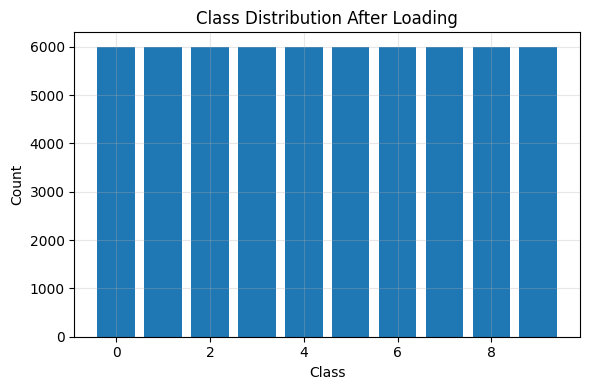


--- Filtering data ---
After filtering: 59400 images remaining


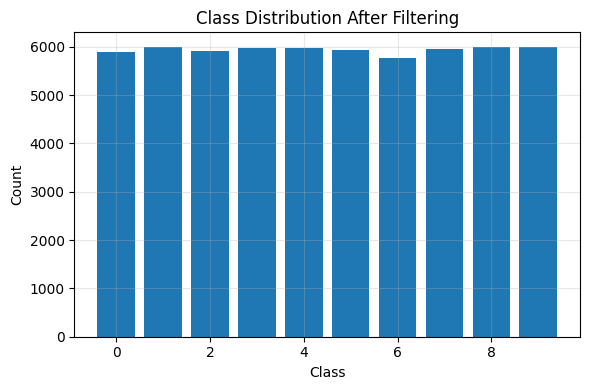


--- Density-based subsampling ---
After density-based subsampling: 4900 images remaining


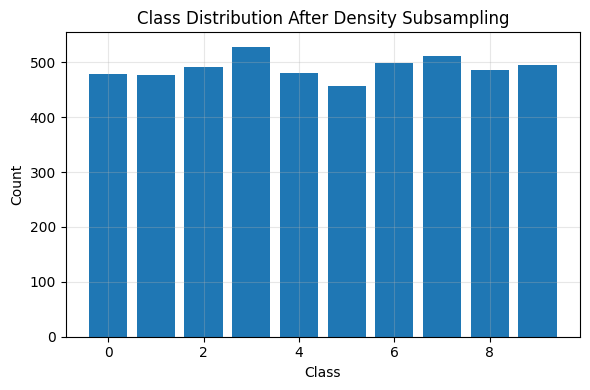


--- Entropy-based ordering for subset selection ---
Data ordered by entropy (highest to lowest) for subset selection


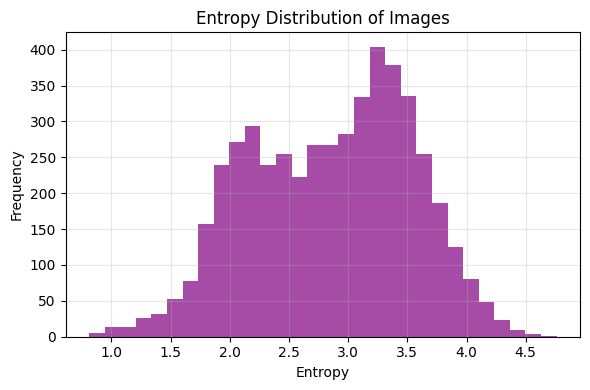


--- Selecting optimal samples ---
Selecting 1000 samples...
Selected 1000 samples
Class distribution: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]


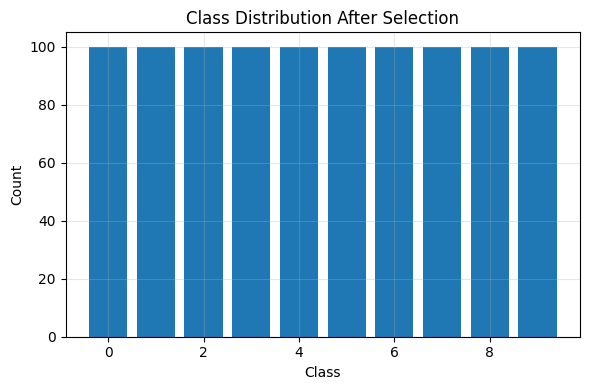


--- Feature extraction ---
Extracting features using method: pca

--- SVD feature extraction ---
Extracting features using SVD with 100 components...
Features shape: (1000, 100)
Explained variance ratio: [0.21512156 0.18093719 0.08204711 0.0564168  0.0368825  0.03420876
 0.0235975  0.01901291 0.01354324 0.01266728]

--- PCA dimensionality reduction ---
Determining optimal PCA components for 95.0% variance...
Components needed for 95.0% variance: 61
Actual variance captured: 0.9509
PCA features shape: (1000, 61)
PCA explained variance ratio (first 10): [0.28222539 0.18514847 0.07589639 0.05246996 0.04092154 0.03795824
 0.02607567 0.02109709 0.01496689 0.0139647 ]
Total variance explained: 0.9509

--- Visualizing principal components ---


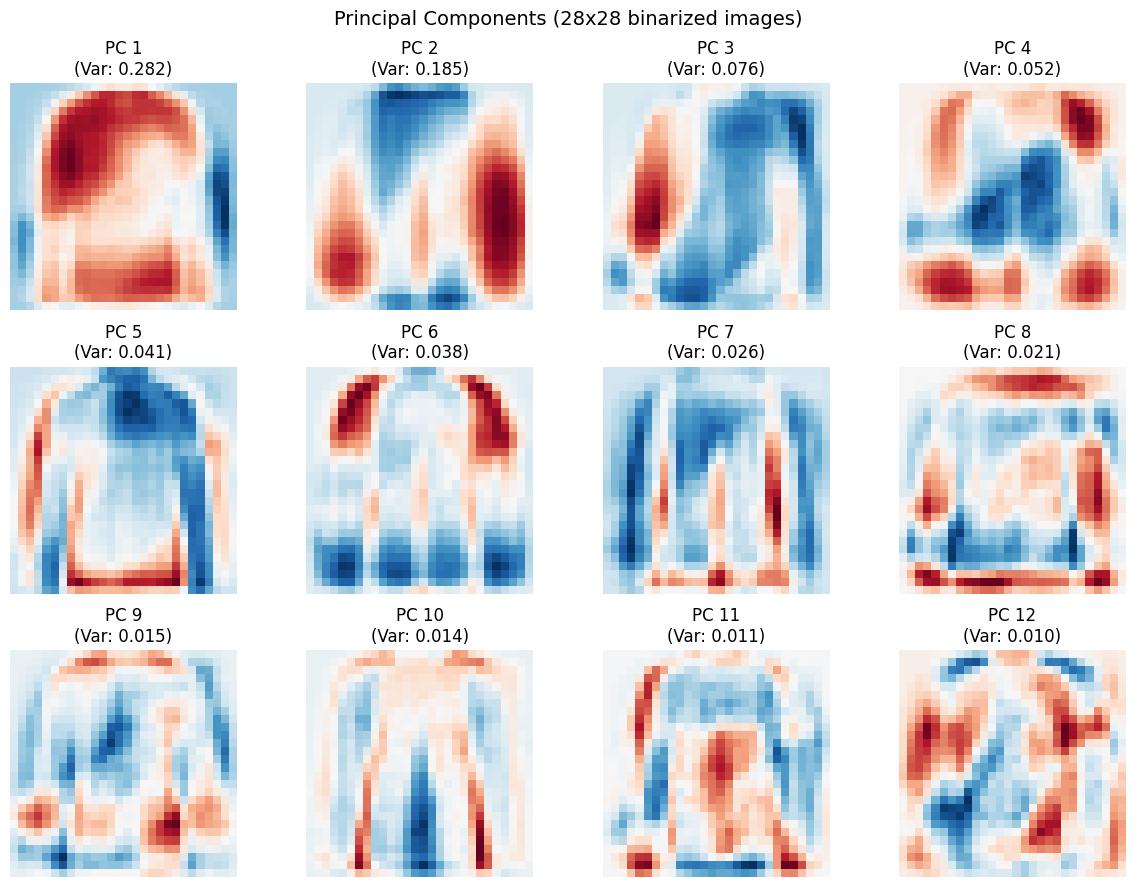


--- Visualizing PCA variance analysis ---


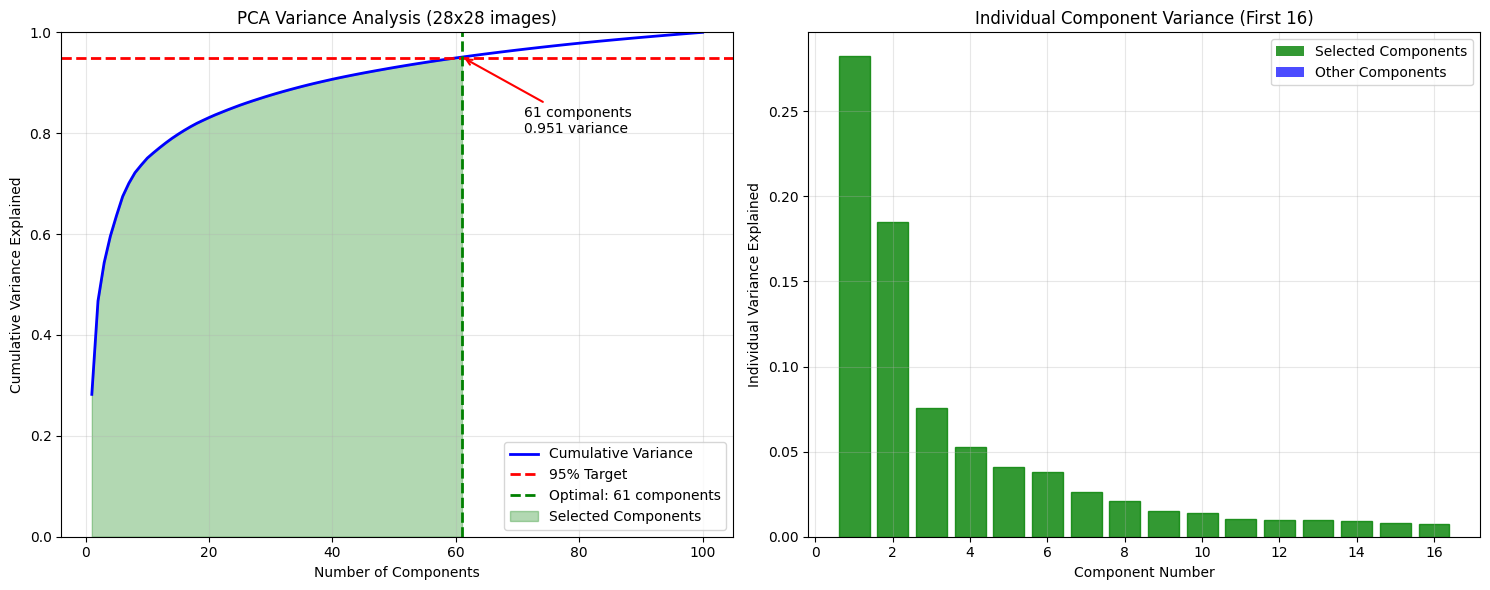


--- Feature whitening ---
Features after whitening - Mean: [ 4.29115077e-16 -4.97157870e-16  1.34559031e-16  1.25233157e-16
 -4.90441021e-17]
Features after whitening - Std: [1. 1. 1. 1. 1.]





--- Training all models ---

--- Entropy-based ordering for curriculum learning ---
Data ordered by entropy (lowest to highest) for curriculum learning

=== Training first with Decision Tree...===
Optimizing decision tree parameters...
Best tree params: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}





=== After ; Decision Tree with Feature Selection + Bagging ===
Selecting top 25 important features using RF...




Decision Tree with Feature Selection + Bagging ; Baseline accuracy: 0.5700
Decision Tree with Feature Selection + Bagging ; Selected features accuracy: 0.6650

=== Lastly  ; training with Random Forest too...===

=== METHOD 1: K-means + Active Learning + KNN ===
Finding optimal k using elbow method...
Selected k = 2 based on Elbow Method




Running X-means-like

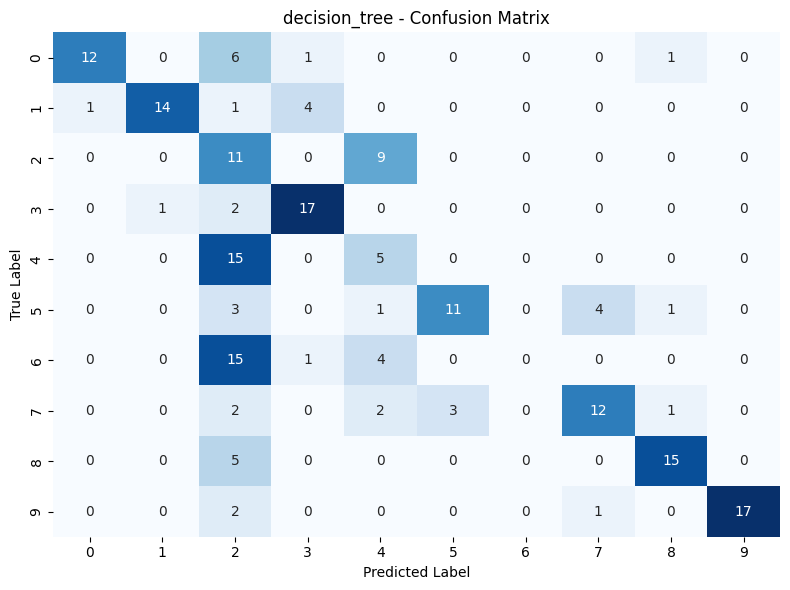

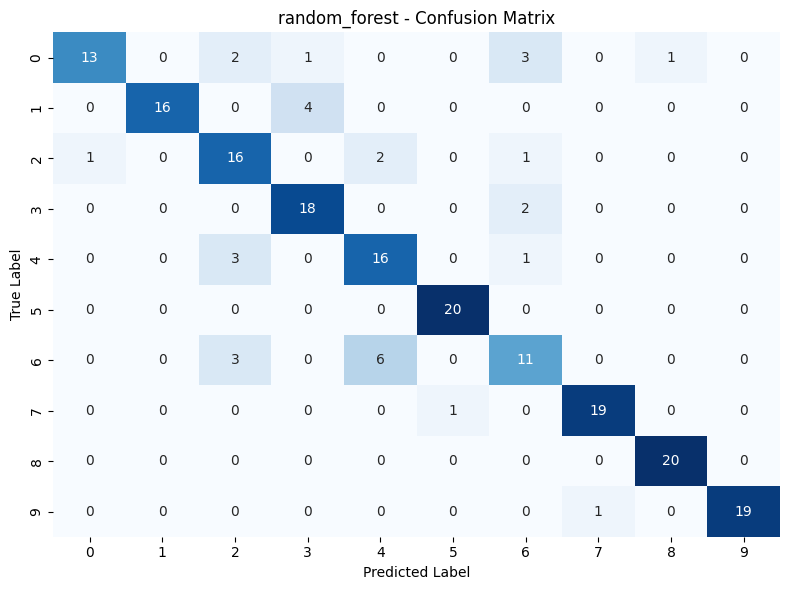

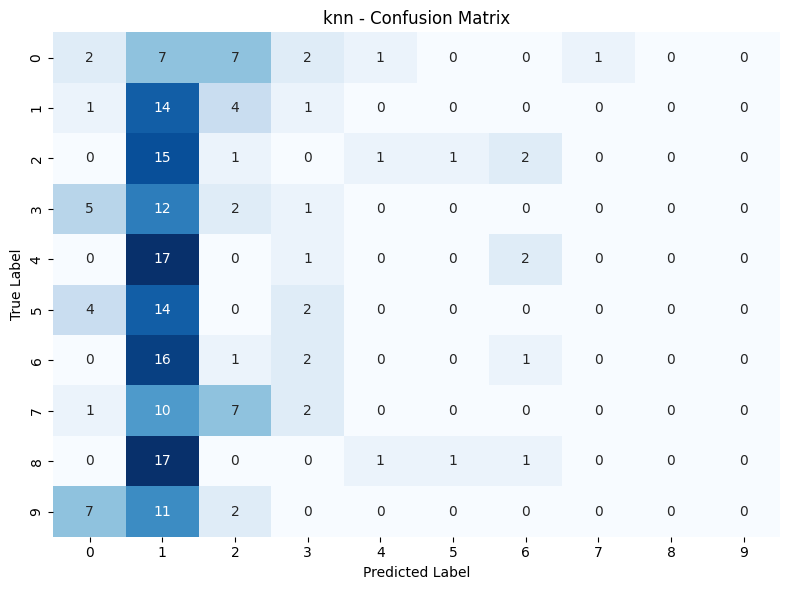

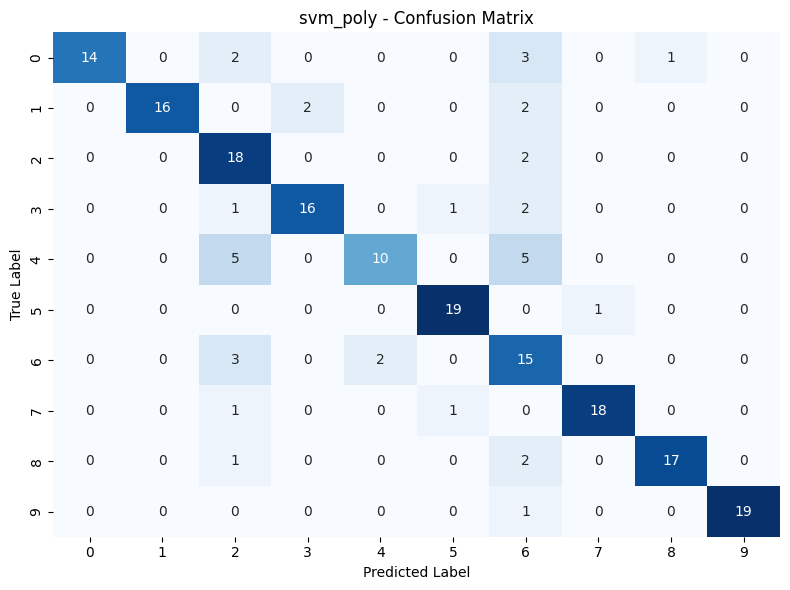

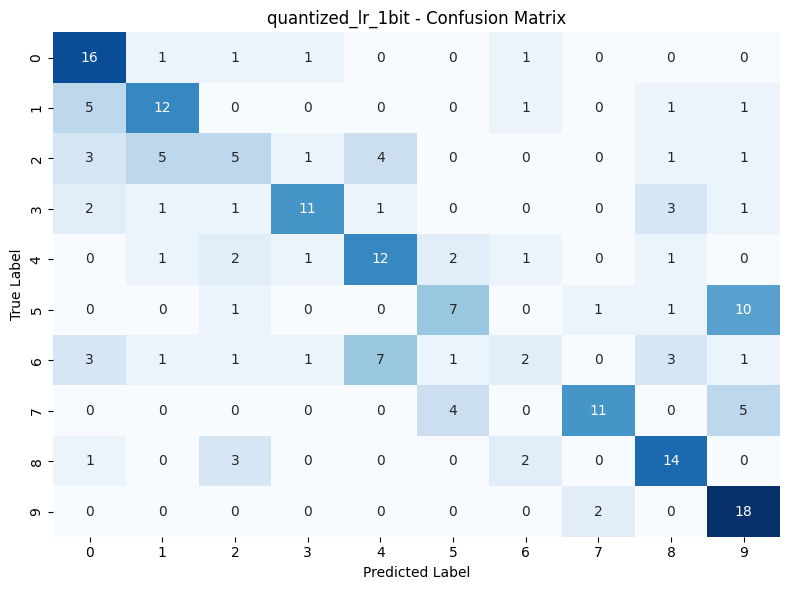

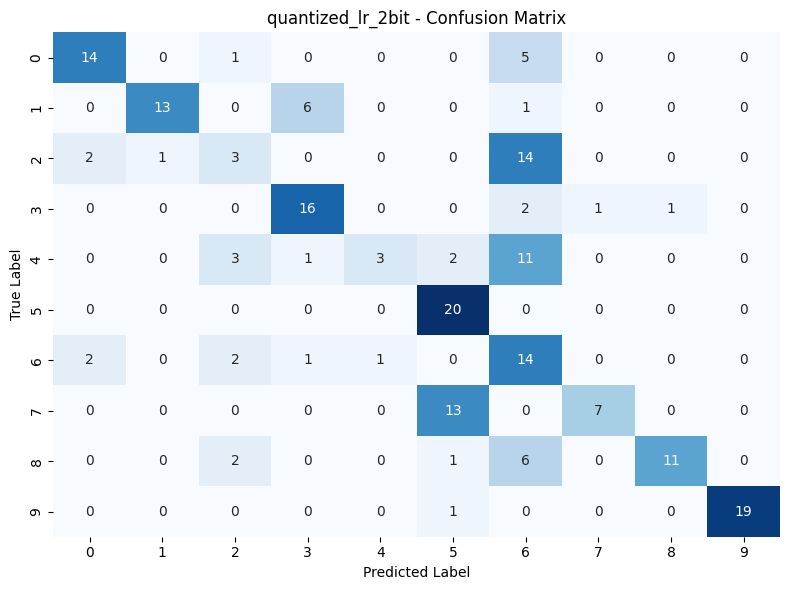

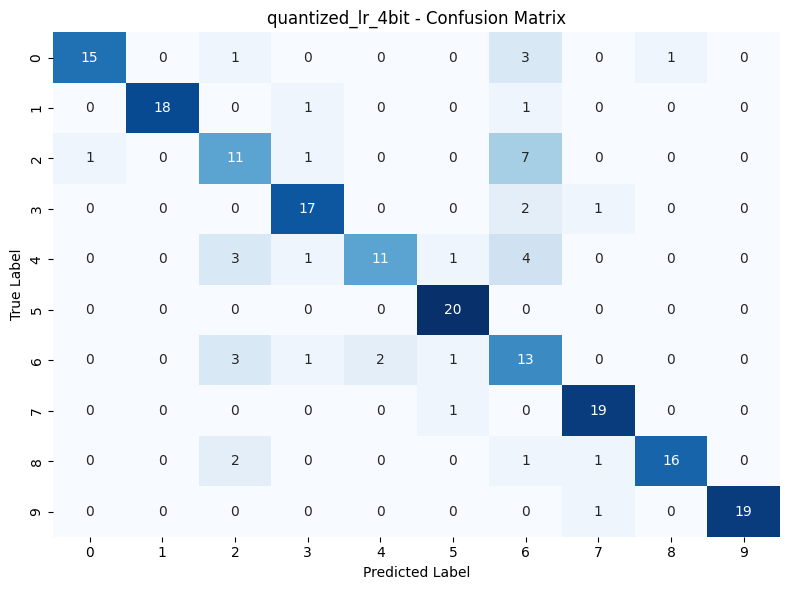

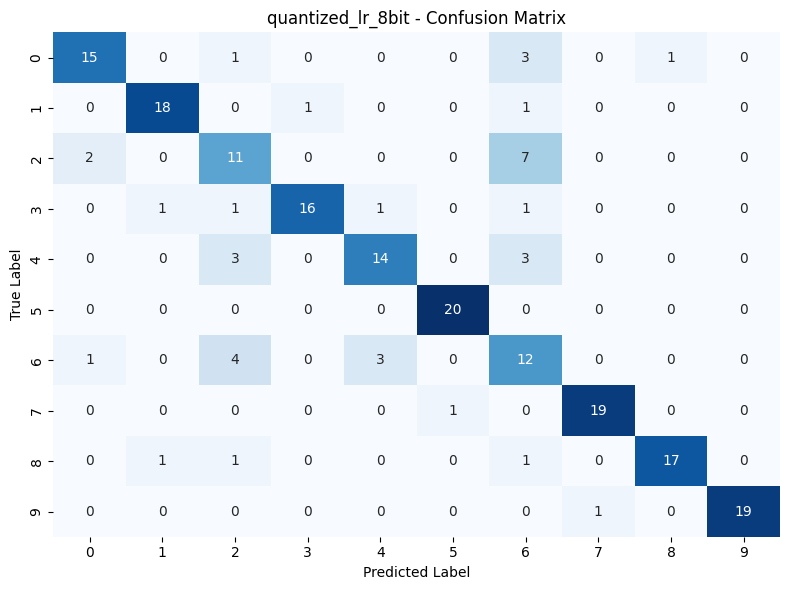


=== Estimating Model Sizes ===
Could not estimate size for decision_tree: 'DigitClassificationPipeline' object has no attribute '_estimate_model_size'
Could not estimate size for random_forest: 'DigitClassificationPipeline' object has no attribute '_estimate_model_size'
Could not estimate size for knn: 'DigitClassificationPipeline' object has no attribute '_estimate_model_size'
Could not estimate size for svm_poly: 'DigitClassificationPipeline' object has no attribute '_estimate_model_size'
 quantized_lr_1bit → 0.07 kB (quantized)
 quantized_lr_2bit → 0.15 kB (quantized)
 quantized_lr_4bit → 0.30 kB (quantized)
 quantized_lr_8bit → 0.60 kB (quantized)
Could not estimate size for decision_tree_selected: 'DigitClassificationPipeline' object has no attribute '_estimate_model_size'


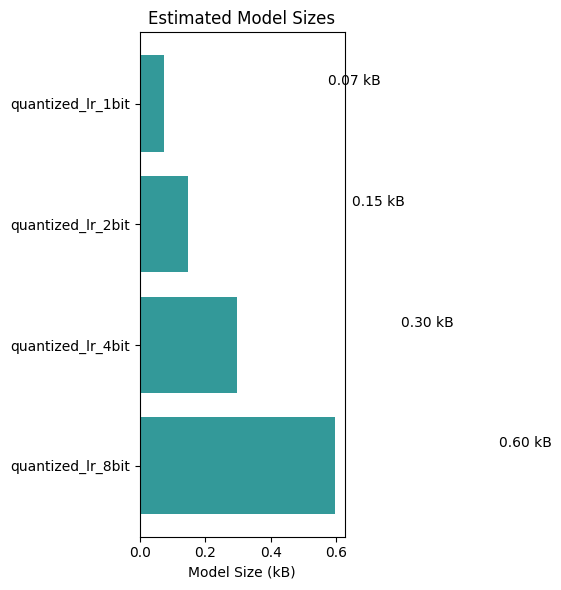

In [67]:



fashion_pipeline = DigitClassificationPipeline(
    
    data_path=None,
    target_samples=1000,
    image_size=(28, 28),
    feature_method='pca',
    optimize_samples=True,
    dataset_name='fashion'
 )




fashion_pipeline.run_pipeline()


fashion_pipeline.evaluate_all_models()


fashion_pipeline.estimate_all_model_sizes_and_plot()






# SUMMARY

In this study, we observed the performances of different models on two different MNIST datasets based on classical machine learning methods and active-curriculum learning-based dataset selection and data sorting; Logistic Regression can be embedded in many microcontrollers with the desired accuracy-size optimization by being quantized and is the most suitable model for the active-curriculum learning process; Afterwards, Decision Tree and Random Forest models and SVM performed quite well, but since the size information of the models cannot be accessed, it is difficult to say anything definitive about their suitability for the hardware at the moment; Finally, the results obtained for the use of K-means and KNN together, where the active learning process was tried to be fully implemented, were very poor, and the reason is not yet understood; this problem will be resolved in future studies, and a more advanced and hardware-suitable version will be worked on...